# Tutorial: DERController


**This tutorial introduces the pandapower `DERController`**

The `DERController` can be used to model Distributed Energy Resource (DER) capabilities for reactive power (Q) provision. The capabilities of reactive power provision may have differnent dependencies:
+ Q(P) capability: defines the reactive power capability depending on the DER active power generation
+ Q(V) capability: defines the reactive power capability depending on the voltage at the DER network connection point

Different local control characteristics are included and can be applied via `DERController`, in particular:
+ const Q: fixed Q setpoint 
+ fixed cosphi: fixed power factor 
+ cosphi(P): power factor-watt function 
+ Q(V): volt- var function
+ Voltage-Limitation function (in German Spannungsbegrenzungsfunktion)

Common DER capabilities and local control characteristics are predefined in DERController according to German Grid Codes. 

**First of all we import all needed packages and libraries:**

In [23]:
# Import used python packages
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
try:
    from cycler import cycler
    cycler_imported = True
except ImportError:
    cycler_imported = False

import pandapower as pp
import pandapower.control.controller.DERController as DERModels
from pandapower.control.controller.DERController.der_control_plot import verify_pq_area, verify_qv_area

**Then, we create a simple grid example:**

In [24]:
def simple_test_net():
    net = pp.create_empty_network()

    pp.create_buses(net, 2, vn_kv=20)

    pp.create_ext_grid(net, 0)
    pp.create_sgen(net, 1, p_mw=1., sn_mva=1.)

    pp.create_line(net, 0, 1, length_km=5.0, std_type="NAYY 4x50 SE")

    return net

Define some timeseries data to check multiple active power injection states.

In [25]:
ts_data = pd.DataFrame({"p_0": np.arange(0, -1.21, -0.05)})
data = pp.timeseries.DFData(ts_data)

**And finally, we define a function that is to plot the P/Q curves and Q/Vm curves from timeseries results:**

In [26]:
def plot_function(): 
    plt.style.use(['seaborn-v0_8-talk'])
    if cycler_imported:
        color_cycle = cycler('color', mcolors.TABLEAU_COLORS) # TABLEAU_COLORS #CSS4_COLORS
    
    # --- Plot P/S .vs. Q/S 
    fig1 = plt.figure(figsize=(16,5))
    gs1 = gridspec.GridSpec(1, 2, wspace=0.3)
    ax1 = fig1.add_subplot(gs1[0])
    ax2 = fig1.add_subplot(gs1[1])
    rcParams["axes.prop_cycle"] = color_cycle
    verify_pq_area(pq_area, pq_area.name(),ax=ax1)
    xs = ow.output["res_sgen.q_mvar"]/net.sgen.sn_mva.loc[0]
    ys = ow.output["res_sgen.p_mw"]/net.sgen.sn_mva.loc[0]
    for x, y in zip(xs[0], ys[0]):
        ax1.scatter(x,y, label = 'operation points',linestyle='-')
    ax1.get_legend().remove()
    ax1.set_ylim(0,1.3)
    ax1.grid(True)
    
    # --- Plot vm_pu .vs. Q/S 
    verify_qv_area(pq_area, pq_area.__class__,ax=ax2)
    # ax2.set_xlabel("vm_pu")
    # ax2.set_ylabel("Q/Sn")
    ax2.grid(alpha=0.8)
    ax2.set_title(pq_area.name())
    xs = ow.output['res_bus.vm_pu'][1]
    ys = ow.output["res_sgen.q_mvar"]/net.sgen.sn_mva.loc[0]
    for x, y in zip(xs, ys[0]):
        ax2.scatter(x ,y, label = 'operation points')
    ax2.get_legend().remove()
    ax2.grid(True)
    handles, labels = ax1.get_legend_handles_labels()
    # axbox = ax2.get_position()
    
    fig1.legend(handles, ['$Q_{min}$','$Q_{max}$','$S_{max}$','operation points'],
                ncol=4,framealpha=0,bbox_to_anchor=[0.7,1.05])
    plt.show()

## Q(P) Capability 
The Q(P) capability defines the reactive power capability of the DERs depending on their active power generation. The Q(P) capability of the DERs are usually defined in the national Requirements for Generators (RfG) or grid codes. 

In this simple example, a Q(P) cpability according to the German medium voltage RfG VDE AR-N 4110 is applied. We set a fixed reactive power setpoint `q=0.5` which is outside of the Q(P)-capability. Consequently, the `DERController` is needed to set the Q provision within its limits. 

The results of the following code, which gets plotted (first look at the plot left!), show that the reactive power is usually limited to `0.33 Sn` which is a power factor of `0.95 overexceited`. If the active power gets lower than `0.2 Sn`, also the reactive power gets reduced.

100%|██████████| 25/25 [00:02<00:00, 11.86it/s]


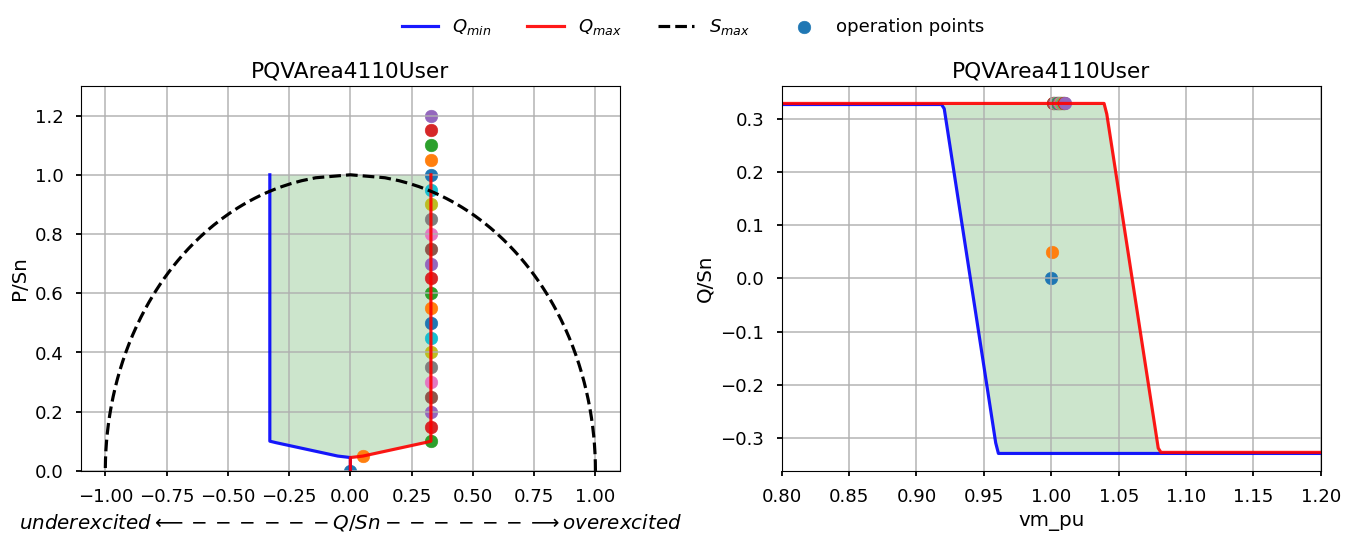

In [27]:
net = simple_test_net()

# define outputs and outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")

# define DERController
pqv_area = DERModels.PQVArea4110User()
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelConstQ(q=0.5),
    pqv_area=pqv_area, saturate_sn_mva=False, q_prio=True,
    data_source=data, p_profile="p_0", profile_scale=-1)
pp.timeseries.run_timeseries(net, time_steps=range(0, 25)) # constQ: Attetion q is NOT in MVAR but relative to SnMVA

# plot results
plot_function()

## Inverter apparent power limitation

The parameter `saturate_sn_mva` can be used to consider limitations to the apparent power of the DER.

+ saturate_sn_mva = False: active and reactive power will not be limited by the DER nominal apparent power (sn_mva)

+ saturate_sn_mva = True (default): active and reactive power will be limited by the DER nominal apparent power (sn_mva)

`q_prio` defines which part of apparent power gets limited to achieve the apparent power limitation. The parameter is only active if `saturate_sn_mva is True`. 

+ q_prio = True (default): DER active power is curtailed

+ q_prio = False: DER reactive power is curtailed


Let's repeat the last calculation with `saturate_sn_mva=True` and `q_prio=True` to see the difference to the last results (again focus on left plot): There are no dots outside the apparent power circle due to reduced active powers.

100%|██████████| 25/25 [00:01<00:00, 15.76it/s]


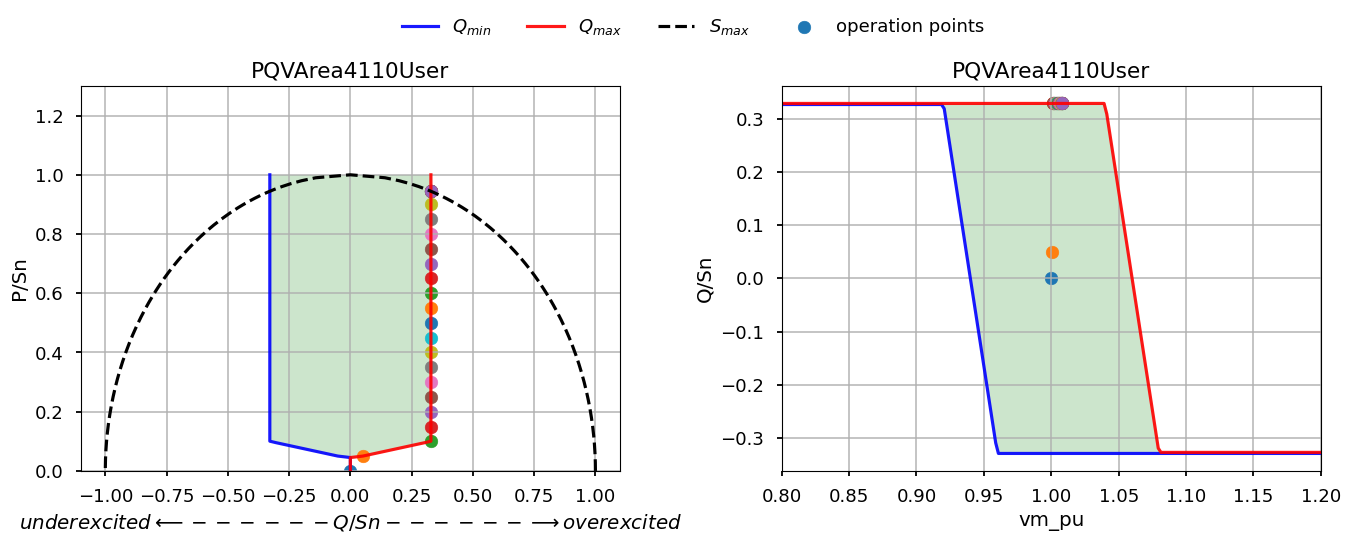

In [28]:
# change saturate_sn_mva using a new controller
net = simple_test_net()

# define outputs and outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")

# define DERController
pq_area = DERModels.PQVArea4110User()
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelConstQ(q=0.5),
    pqv_area=pq_area, saturate_sn_mva=True, q_prio=True,
    data_source=data, p_profile="p_0", profile_scale=-1)

# run timeseries and plot results
pp.timeseries.run_timeseries(net, time_steps=range(0, 25))
plot_function()

If we consider `q_prio=False`, we can see in the left plot, that, for some operation points, q is reduced to zero to hold apparent power limits:

100%|██████████| 25/25 [00:01<00:00, 15.17it/s]


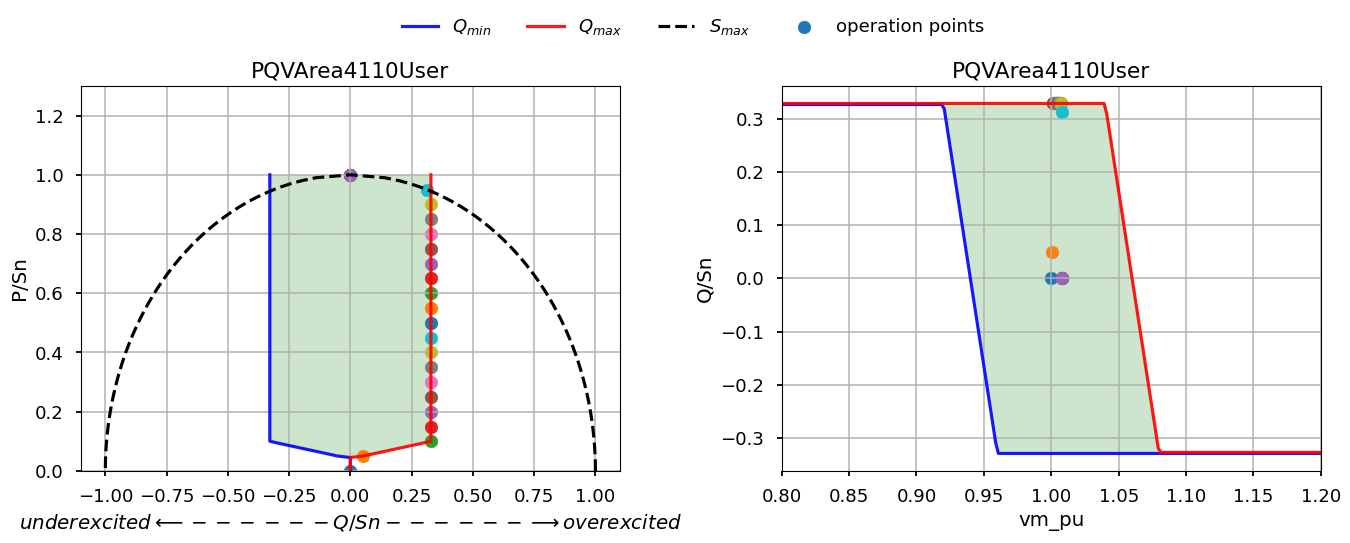

In [29]:
# change q_prio using a new controller
net = simple_test_net()

# define outputs and outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")

# define DERController
pq_area = DERModels.PQVArea4110User()
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelConstQ(q=0.5),
    pqv_area=pq_area, saturate_sn_mva=True, q_prio=False,
    data_source=data, p_profile="p_0", profile_scale=-1)

# run timeseries and plot results
pp.timeseries.run_timeseries(net, time_steps=range(0, 25))
plot_function()

## Q(V) capability and voltage limitation function 

To visualize limiting the reactive power depending on the voltage of the RES connection point, we set the line length to 40 km. Then there is sufficient voltage rise to show that the controller reacts on over voltages via decreasing the inductive reactive power provision (overexcited behavior). That reduction is not used if the active power is low since then no overvoltages occur.

Note that the apparent power limit is considered simultaneously.

100%|██████████| 25/25 [00:01<00:00, 14.94it/s]


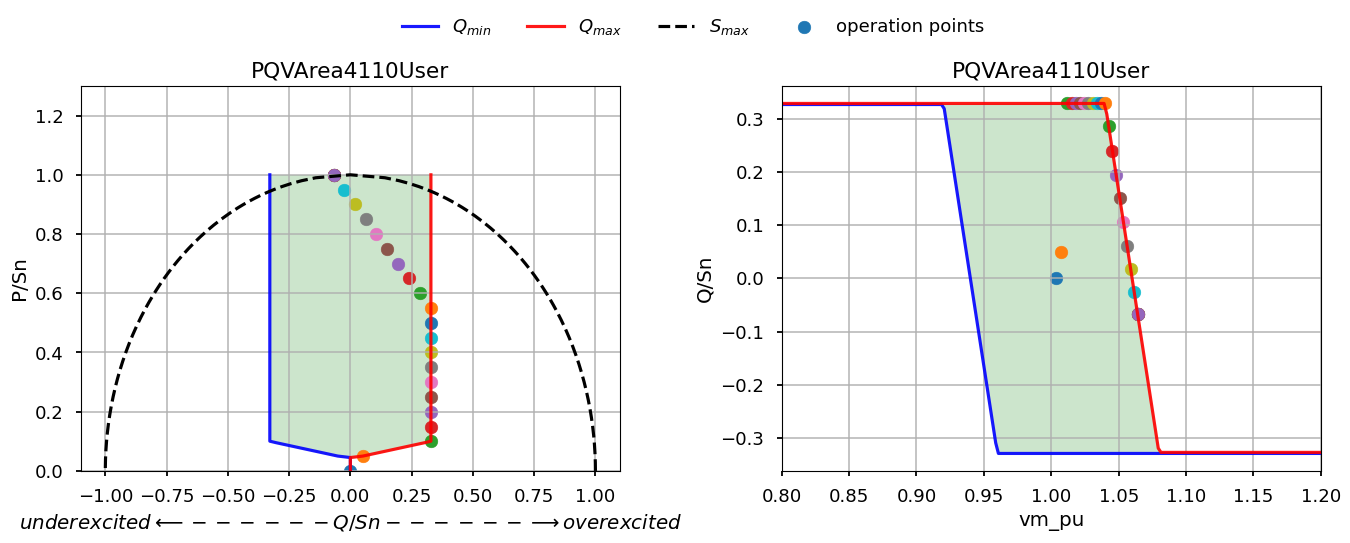

In [30]:
# change line length to cause voltage issues
# run controller
net = simple_test_net()
net.line["length_km"] = 40

# define outputs and outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")

# define DERController
pq_area = DERModels.PQVArea4110User()
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelConstQ(q=0.5), pqv_area=pq_area,
    data_source=data, p_profile="p_0", profile_scale=-1)
pp.timeseries.run_timeseries(net, time_steps=range(0, 25))
plot_function()

### Cosphi(P) curve
## "explination here"

100%|██████████| 25/25 [04:15<00:00, 10.24s/it]


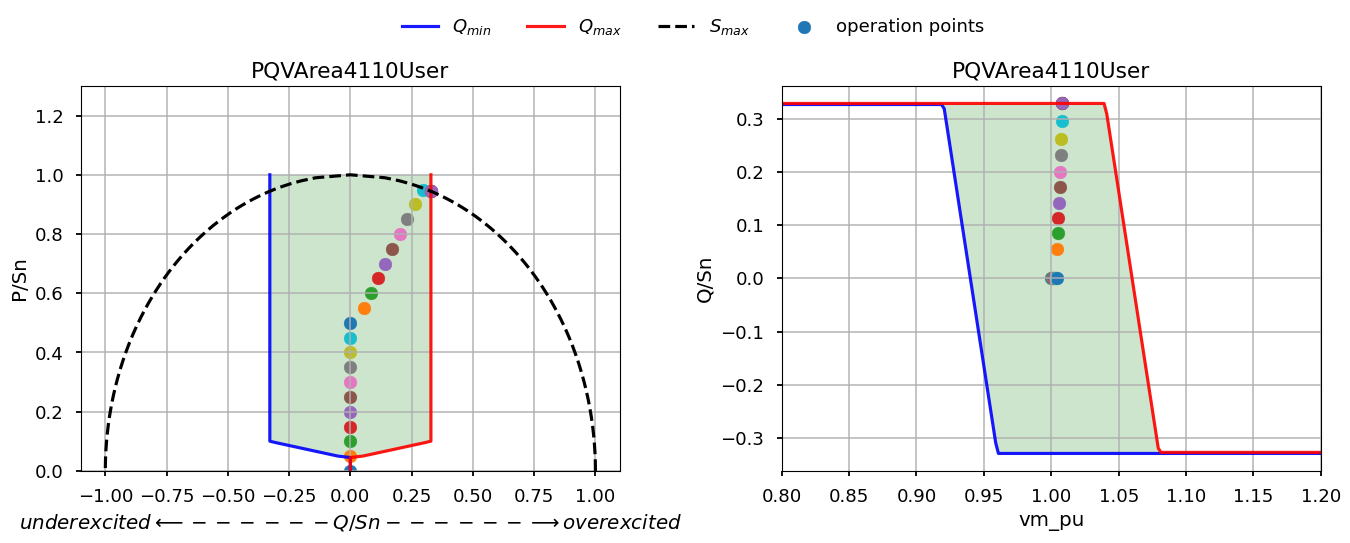

In [31]:
net = simple_test_net()

# Create, add output and set outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")
pq_area = DERModels.PQVArea4110User()

# Cosphi(P) curve 
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelCosphiPCurve(cosphi_p_curve={
        'p_points':(0, 0.5, 1), 'cosphi_points':(1, 1, 0.95)}),
    pqv_area=pq_area, saturate_sn_mva=True, q_prio=True,
    data_source=data, p_profile="p_0", profile_scale=-1)
pp.timeseries.run_timeseries(net, time_steps=range(0, 25))
plot_function()

### Cosphi(P)   
## "explination here"

100%|██████████| 25/25 [00:01<00:00, 17.64it/s]


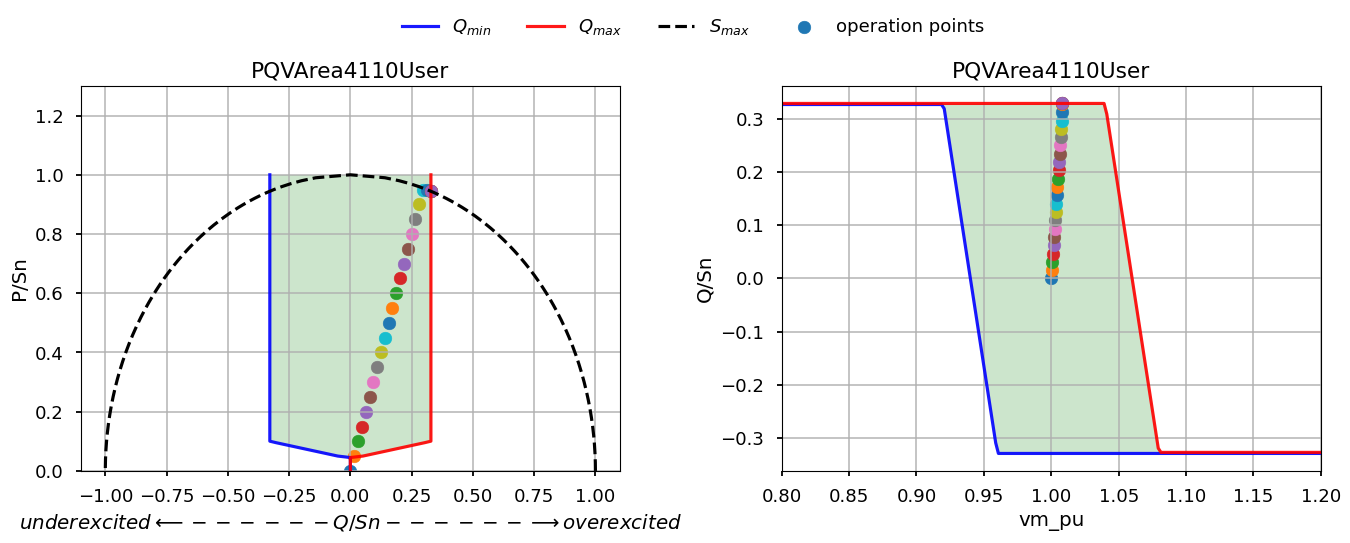

In [32]:
net = simple_test_net()

# Create, add output and set outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")
pq_area = DERModels.PQVArea4110User()

# Cosphi(P)
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelCosphiP(cosphi=0.95),
    pqv_area=pq_area, saturate_sn_mva=True, q_prio=True,
    data_source=data, p_profile="p_0", profile_scale=-1)

pp.timeseries.run_timeseries(net, time_steps=range(0, 25))
plot_function()

### Q(U) curve
## "explination here"

100%|██████████| 25/25 [00:01<00:00, 14.76it/s]


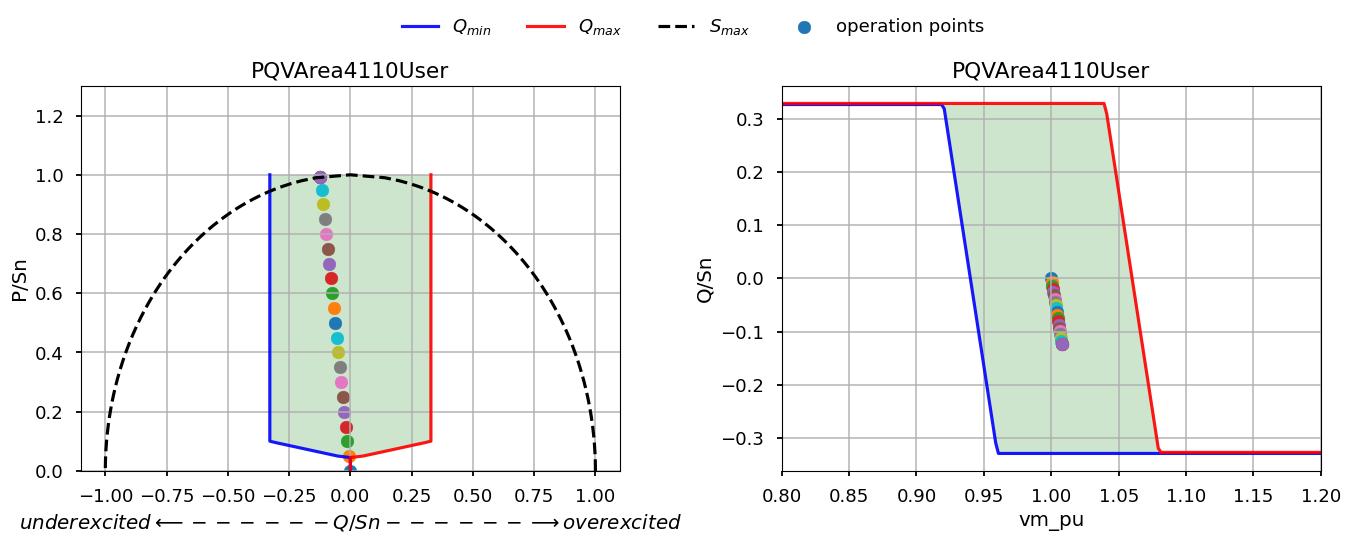

In [33]:
net = simple_test_net()

# Create, add output and set outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")
pq_area = DERModels.PQVArea4110User()

# Q(U) curve
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelQV(qv_curve=DERModels.QVCurve(
        v_points_pu=(0, 0.90, 1.00, 1.02, 2),
        q_points=(0.312, 0.312, 0, -0.312, -0.312))),
    pqv_area=pq_area, saturate_sn_mva=True, q_prio=True, data_source=data,
    p_profile="p_0", profile_scale=-1)

pp.timeseries.run_timeseries(net, time_steps=range(0, 25))
plot_function()

### Statcom  capability
This capability does not depend on active power P, it can provide reactive power Q without active power.
<br>
min_q, max_q : reactive power limits, adjustable and user defined parameters. 


100%|██████████| 25/25 [00:01<00:00, 15.20it/s]


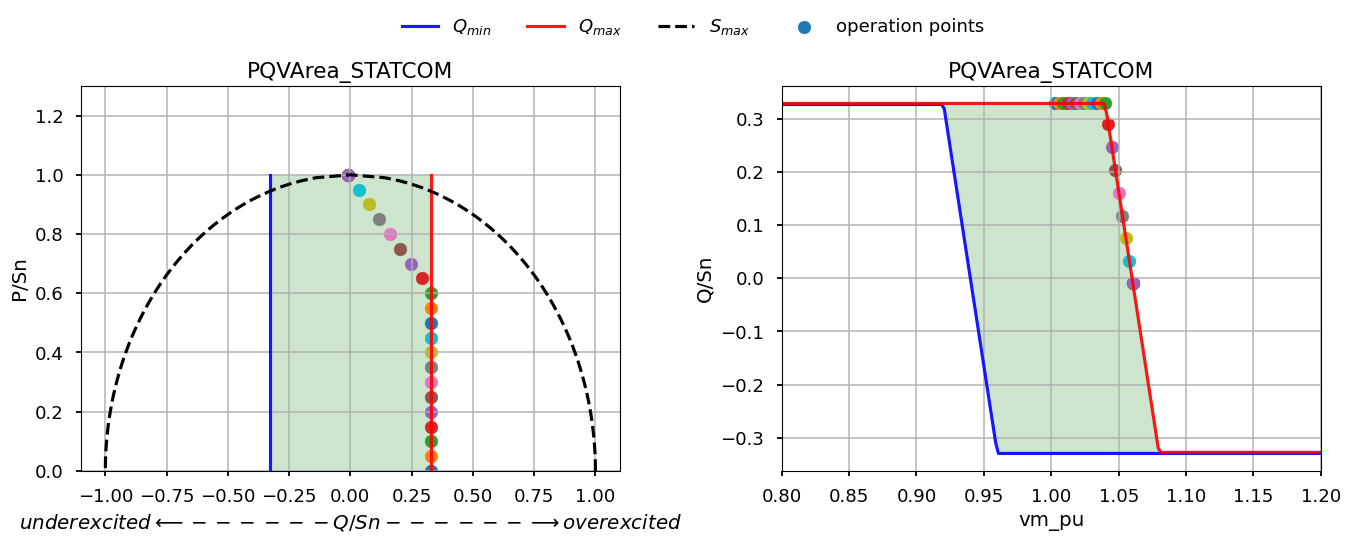

In [34]:
net = simple_test_net()

# Create, add output and set outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")
pq_area = DERModels.PQVArea_STATCOM(min_q=-0.33, max_q=0.33)
net.sgen.sn_mva *= 8
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelConstQ(q=0.5),
    pqv_area=pq_area, saturate_sn_mva=True, q_prio=True,
    data_source=data, p_profile="p_0", profile_scale=-8)
pp.timeseries.run_timeseries(net, time_steps=range(0, 25))
plot_function()

### Fix PF capability 

100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


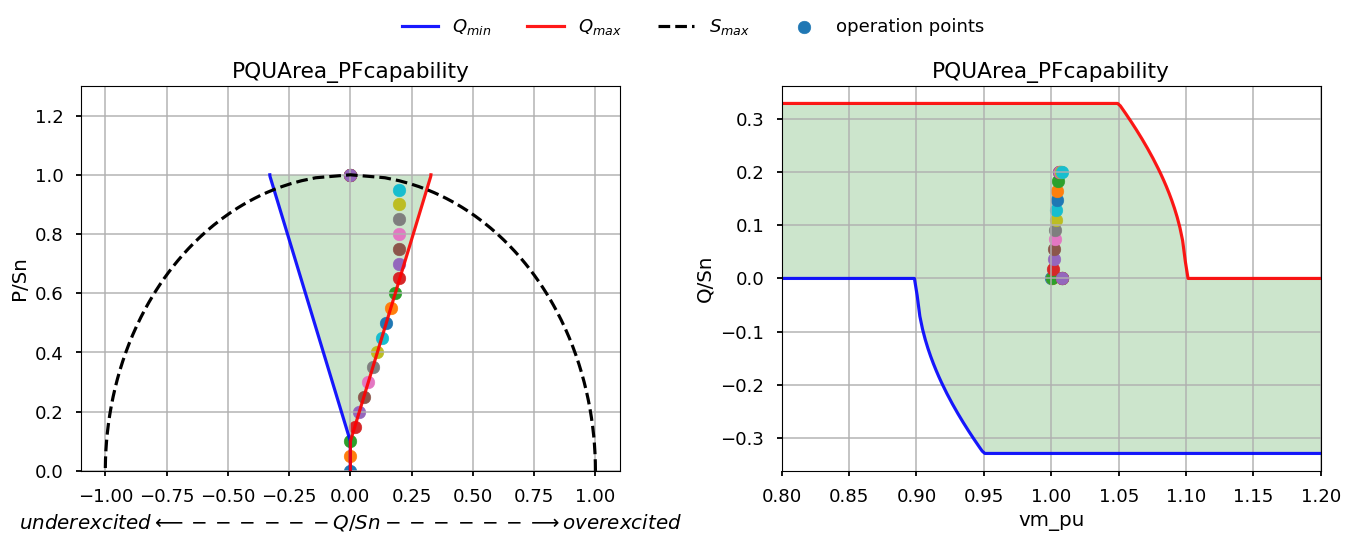

In [35]:
net = simple_test_net()

# Create, add output and set outputwriter
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_sgen", "p_mw")
ow.log_variable("res_sgen", "q_mvar")
pq_area = DERModels.PQUArea_PFcapability(min_q=-0.33, max_q=0.33)
ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelConstQ(q=0.2),
    pqv_area=pq_area, saturate_sn_mva=True, q_prio=False,
    data_source=data, p_profile="p_0", profile_scale=-1)
pp.timeseries.run_timeseries(net, time_steps=range(0, 25))
plot_function()